In [ ]:
import json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load dataset
with open('databot.json') as f:
    data = json.load(f)


In [ ]:
# Ekstraksi fitur
def combine_features(row):
    return f"{row['kategori_hotel']} {row['klasifikasi_hotel']} {row['rating_hotel']} {' '.join(row['fasilitas'])}"

df = pd.DataFrame(data)
df['combined_features'] = df.apply(combine_features, axis=1)

In [ ]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['combined_features']).toarray()

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['kategori_hotel'])
y = to_categorical(y)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Membangun model neural network untuk ekstraksi fitur
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Pelatihan model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
25/25 [==============================] - 1s 12ms/step - loss: 1.7065 - accuracy: 0.3129 - val_loss: 1.6192 - val_accuracy: 0.4450
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 1.5032 - accuracy: 0.4531 - val_loss: 1.4093 - val_accuracy: 0.4750
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 1.2846 - accuracy: 0.5419 - val_loss: 1.2056 - val_accuracy: 0.6700
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 1.0970 - accuracy: 0.6496 - val_loss: 0.9664 - val_accuracy: 0.7400
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.8475 - accuracy: 0.7622 - val_loss: 0.7605 - val_accuracy: 0.8000
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.7178 - accuracy: 0.8085 - val_loss: 0.6211 - val_accuracy: 0.8200
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5872 - accuracy: 0.8373 - val_loss: 0.5341 - val_accuracy: 0.8400
Epoch 8/20
25/25 [=

In [ ]:
# Menggunakan model untuk mendapatkan fitur representasi
feature_model = Sequential()
feature_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
feature_model.add(Dropout(0.5))
feature_model.add(Dense(64, activation='relu'))
feature_model.add(Dropout(0.5))

# Menyalin bobot dari model pelatihan ke model ekstraksi fitur
for layer_tgt, layer_src in zip(feature_model.layers, model.layers[:-1]):
    layer_tgt.set_weights(layer_src.get_weights())

# Mendapatkan fitur representasi untuk seluruh data
X_features = feature_model.predict(X)

32/32 [==============================] - 0s 1ms/step


In [ ]:
# Fungsi untuk merekomendasikan hotel menggunakan cosine similarity
def recommend_hotels(user_input, num_recommendations=3):
    user_feature_matrix = tfidf.transform([user_input]).toarray()
    user_features = feature_model.predict(user_feature_matrix)
    similarities = cosine_similarity(user_features, X_features)
    hotel_indices = similarities.argsort()[0][::-1][:num_recommendations]
    recommended_hotels = [df.iloc[idx].to_dict() for idx in hotel_indices]
    return recommended_hotels

In [ ]:
# Evaluasi model
y_pred = model.predict(X_test)
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

7/7 [==============================] - 0s 2ms/step
Precision: 0.7657281248978068
Recall: 0.6915032679738561
F1 Score: 0.6891684718417733
Accuracy: 0.895


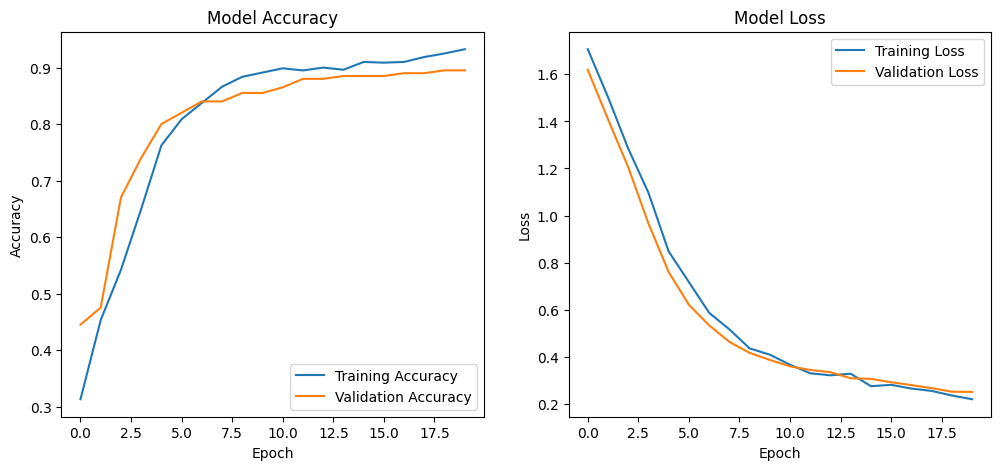

In [ ]:
# Menampilkan grafik akurasi dan loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()